#AI VIET NAM
# Transfer Learning

In [ ]:
import os
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchvision import datasets, models, transforms

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

##**1. Load Flower dataset**

In [ ]:
%cd /dataset.

In [ ]:
!gdown 11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-

Downloading...
From: https://drive.google.com/uc?id=11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-
To: /content/flower_photos.zip
100% 230M/230M [00:02<00:00, 90.8MB/s]


In [ ]:
!unzip ./flower_photos.zip

##**2. Preprocessing**

**Load Dataset from Path**

In [ ]:
data_pạth = "./dataset/flower_photos"

In [ ]:
# load image from path

dataset = datasets.ImageFolder(root=data_pạth)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 3670
    Root location: ./dataset/flower_photos

In [ ]:
num_samples = len(dataset)
num_samples

3670

In [ ]:
dataset.classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
num_classes = len(dataset.classes)

**Training : validation : testing = 0.8 : 0.1 : 0.1**

In [ ]:
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1

n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples

In [ ]:
n_train_examples, n_valid_examples, n_test_examples

(2936, 367, 367)

In [ ]:
train_dataset, valid_dataset, test_dataset = data.random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)

**Augmentation**

In [ ]:
# resize + convert to tensor
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

##**3. Dataloader**

In [ ]:
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE
)

test_dataloader = data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

In [ ]:
inputs, labels = next(iter(train_dataloader))

In [ ]:
inputs.shape

torch.Size([256, 3, 224, 224])

In [ ]:
len(train_dataloader)

12

##**4. Trainer**

In [ ]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=5):
    model.train()
    accs, losses = [], []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        total_acc = (predictions.argmax(1) == labels).sum().item()
        acc = total_acc / labels.size(0)
        accs.append(acc)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), sum(accs) / len(accs)
                )
            )
            start_time = time.time()

    epoch_acc = sum(accs) / len(accs)
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, valid_dataloader):
    model.eval()
    accs, losses = [], []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc = (predictions.argmax(1) == labels).sum().item()
            acc = total_acc / labels.size(0)
            accs.append(acc)

    epoch_acc = sum(accs) / len(accs)
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

##**4. Model**

###**4.1. From Scratch**

In [ ]:
model = models.resnet18(weights=None)

In [ ]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
predictions = model(inputs.to(device))

In [ ]:
predictions.shape

torch.Size([256, 5])

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
loss = criterion(predictions, labels.to(device))
loss

tensor(1.7518, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
train_acc, train_loss

| epoch   0 |     5/   12 batches | accuracy    0.338
| epoch   0 |    10/   12 batches | accuracy    0.418


(0.4293402777777778, 1.5094538033008575)

In [ ]:
eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader)
eval_acc, eval_loss

(0.21086711711711711, 3.8904836177825928)

In [ ]:
base_model = models.resnet18(weights=None)
in_features = base_model.fc.in_features
base_model.fc = nn.Linear(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.0001)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'base_model'

base_model, base_metrics = train(
    base_model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |     5/   12 batches | accuracy    0.410
| epoch   1 |    10/   12 batches | accuracy    0.483
-----------------------------------------------------------
| End of epoch   1 | Time: 24.84s | Train Accuracy    0.488 | Train Loss    1.261 | Valid Accuracy    0.243 | Valid Loss    2.478 
-----------------------------------------------------------
| epoch   2 |     5/   12 batches | accuracy    0.637
| epoch   2 |    10/   12 batches | accuracy    0.634
-----------------------------------------------------------
| End of epoch   2 | Time: 22.33s | Train Accuracy    0.638 | Train Loss    0.940 | Valid Accuracy    0.284 | Valid Loss    2.105 
-----------------------------------------------------------
| epoch   3 |     5/   12 batches | accuracy    0.704
| epoch   3 |    10/   12 batches | accuracy    0.715
-----------------------------------------------------------
| End of epoch   3 | Time: 23.25s | Train Accuracy    0.719 | Train Loss    0.758 | Valid Accuracy    0.480 | Vali

In [ ]:
test_acc, test_loss = evaluate_epoch(base_model, criterion, test_dataloader)
test_acc, test_loss

(0.7311373873873874, 0.9084880948066711)

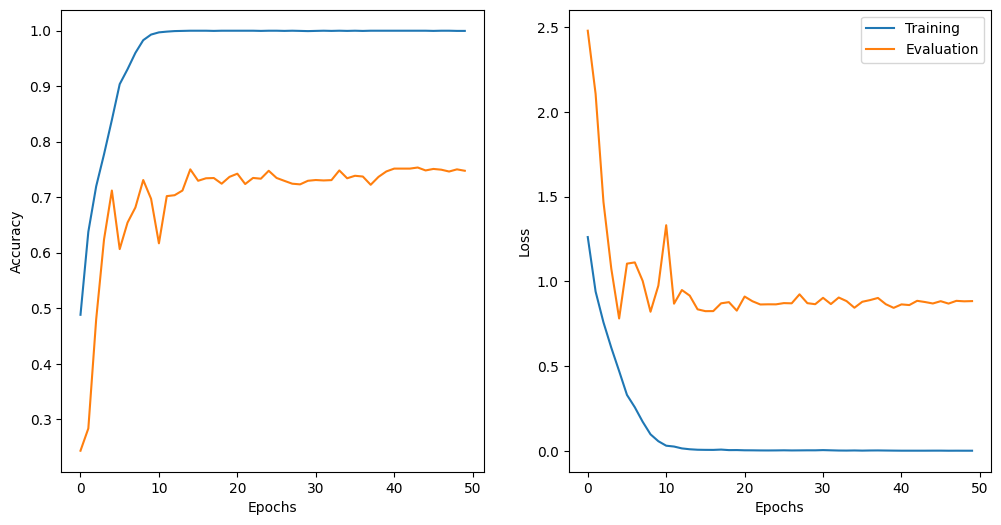

In [ ]:
plot_result(
    num_epochs,
    base_metrics["train_accuracy"],
    base_metrics["valid_accuracy"],
    base_metrics["train_loss"],
    base_metrics["valid_loss"]
)

###**4.2.Transfer Learning**

In [ ]:
model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model.parameters():
   param.requires_grad = False

In [ ]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
transfer_model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)
# freeze FE
for param in transfer_model.parameters():
   param.requires_grad = False

in_features = transfer_model.fc.in_features
transfer_model.fc = nn.Linear(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transfer_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters(), lr=0.0001)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'transfer_model'

transfer_model, transfer_metrics = train(
    transfer_model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |     5/   12 batches | accuracy    0.182
| epoch   1 |    10/   12 batches | accuracy    0.192
-----------------------------------------------------------
| End of epoch   1 | Time: 21.13s | Train Accuracy    0.196 | Train Loss    1.742 | Valid Accuracy    0.233 | Valid Loss    1.676 
-----------------------------------------------------------
| epoch   2 |     5/   12 batches | accuracy    0.247
| epoch   2 |    10/   12 batches | accuracy    0.264
-----------------------------------------------------------
| End of epoch   2 | Time: 23.12s | Train Accuracy    0.269 | Train Loss    1.636 | Valid Accuracy    0.338 | Valid Loss    1.586 
-----------------------------------------------------------
| epoch   3 |     5/   12 batches | accuracy    0.316
| epoch   3 |    10/   12 batches | accuracy    0.334
-----------------------------------------------------------
| End of epoch   3 | Time: 21.72s | Train Accuracy    0.343 | Train Loss    1.556 | Valid Accuracy    0.405 | Vali

In [ ]:
test_acc, test_loss = evaluate_epoch(transfer_model, criterion, test_dataloader)
test_acc, test_loss

(0.8697740709459459, 0.514044776558876)

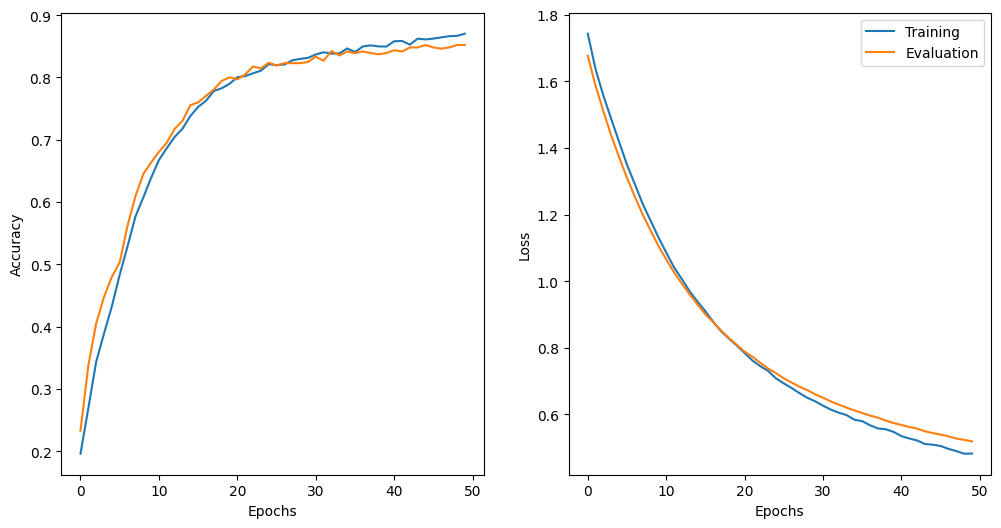

In [ ]:
plot_result(
    num_epochs,
    transfer_metrics["train_accuracy"],
    transfer_metrics["valid_accuracy"],
    transfer_metrics["train_loss"],
    transfer_metrics["valid_loss"]
)

###**4.3. Fine-Tuning**

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# freeze the first 50 layers
num_layers = 50
for index, param in enumerate(model.parameters()):
    if index < num_layers:
        param.requires_grad = False

In [ ]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
fine_tuning_model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)

# freeze the first 50 layers
num_layers = 50
for index, param in enumerate(fine_tuning_model.parameters()):
    if index < num_layers:
        param.requires_grad = False

in_features = fine_tuning_model.fc.in_features
fine_tuning_model.fc = nn.Linear(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fine_tuning_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tuning_model.parameters(), lr=0.0001)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'fine_tuning_model'

fine_tuning_model, fine_tuning_metrics = train(
    fine_tuning_model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |     5/   12 batches | accuracy    0.482
| epoch   1 |    10/   12 batches | accuracy    0.623
-----------------------------------------------------------
| End of epoch   1 | Time: 22.53s | Train Accuracy    0.642 | Train Loss    0.982 | Valid Accuracy    0.839 | Valid Loss    0.523 
-----------------------------------------------------------
| epoch   2 |     5/   12 batches | accuracy    0.874
| epoch   2 |    10/   12 batches | accuracy    0.883
-----------------------------------------------------------
| End of epoch   2 | Time: 22.11s | Train Accuracy    0.886 | Train Loss    0.383 | Valid Accuracy    0.883 | Valid Loss    0.315 
-----------------------------------------------------------
| epoch   3 |     5/   12 batches | accuracy    0.928
| epoch   3 |    10/   12 batches | accuracy    0.928
-----------------------------------------------------------
| End of epoch   3 | Time: 21.66s | Train Accuracy    0.931 | Train Loss    0.247 | Valid Accuracy    0.910 | Vali

In [ ]:
test_acc, test_loss = evaluate_epoch(fine_tuning_model, criterion, test_dataloader)
test_acc, test_loss

(0.9313590934684685, 0.2318771481513977)

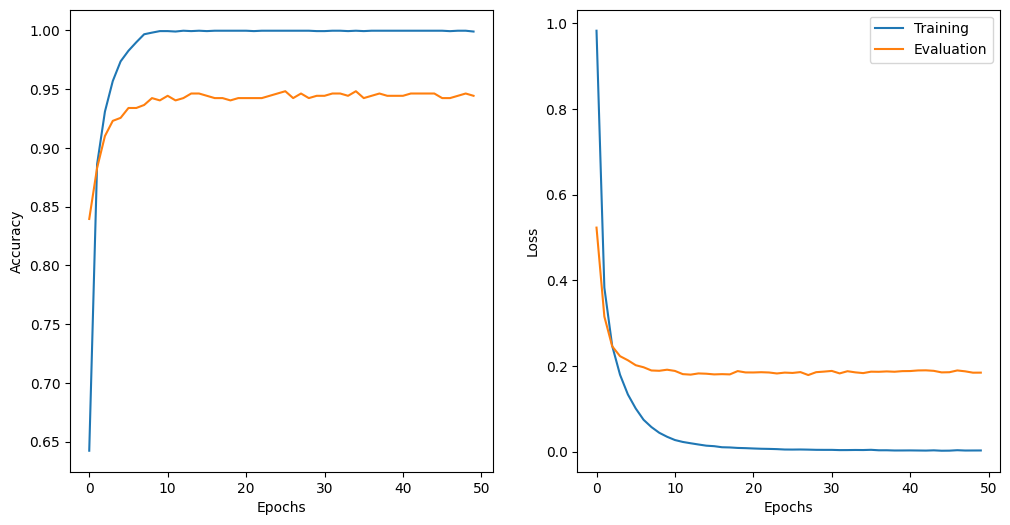

In [ ]:
plot_result(
    num_epochs,
    fine_tuning_metrics["train_accuracy"],
    fine_tuning_metrics["valid_accuracy"],
    fine_tuning_metrics["train_loss"],
    fine_tuning_metrics["valid_loss"]
)

###**4.4. Fine-Tuning (Initilization)**

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [ ]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
initilization_model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
    )

in_features = initilization_model.fc.in_features
initilization_model.fc = nn.Linear(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
initilization_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(initilization_model.parameters(), lr=0.0001)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'initilization_model'

initilization_model, initilization_metrics = train(
    initilization_model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |     5/   12 batches | accuracy    0.604
| epoch   1 |    10/   12 batches | accuracy    0.719
-----------------------------------------------------------
| End of epoch   1 | Time: 22.66s | Train Accuracy    0.732 | Train Loss    0.793 | Valid Accuracy    0.854 | Valid Loss    0.366 
-----------------------------------------------------------
| epoch   2 |     5/   12 batches | accuracy    0.935
| epoch   2 |    10/   12 batches | accuracy    0.940
-----------------------------------------------------------
| End of epoch   2 | Time: 21.88s | Train Accuracy    0.942 | Train Loss    0.204 | Valid Accuracy    0.919 | Valid Loss    0.206 
-----------------------------------------------------------
| epoch   3 |     5/   12 batches | accuracy    0.976
| epoch   3 |    10/   12 batches | accuracy    0.982
-----------------------------------------------------------
| End of epoch   3 | Time: 24.68s | Train Accuracy    0.980 | Train Loss    0.088 | Valid Accuracy    0.935 | Vali

In [ ]:
test_acc, test_loss = evaluate_epoch(initilization_model, criterion, test_dataloader)
test_acc, test_loss

(0.9526851069819819, 0.20071009546518326)

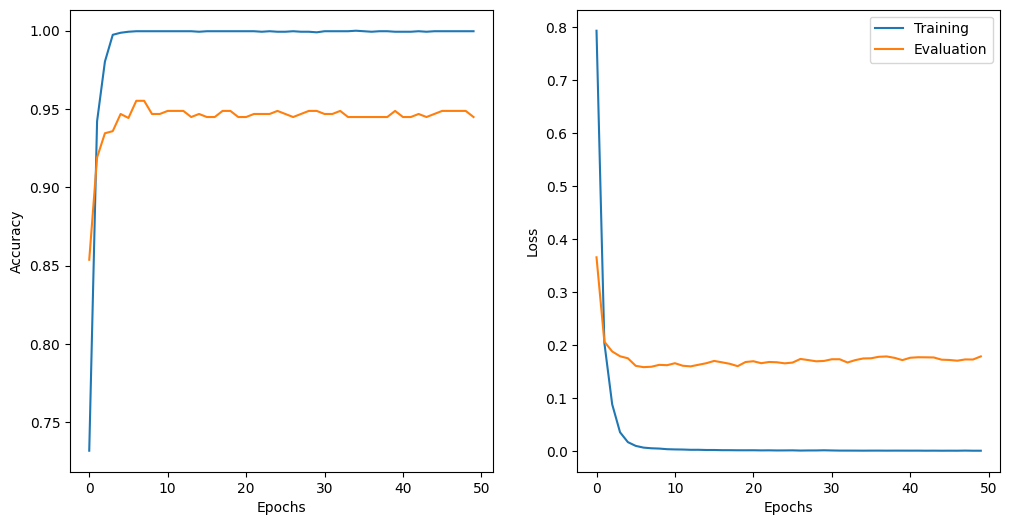

In [ ]:
plot_result(
    num_epochs,
    initilization_metrics["train_accuracy"],
    initilization_metrics["valid_accuracy"],
    initilization_metrics["train_loss"],
    initilization_metrics["valid_loss"]
)

##**5. Comparing**

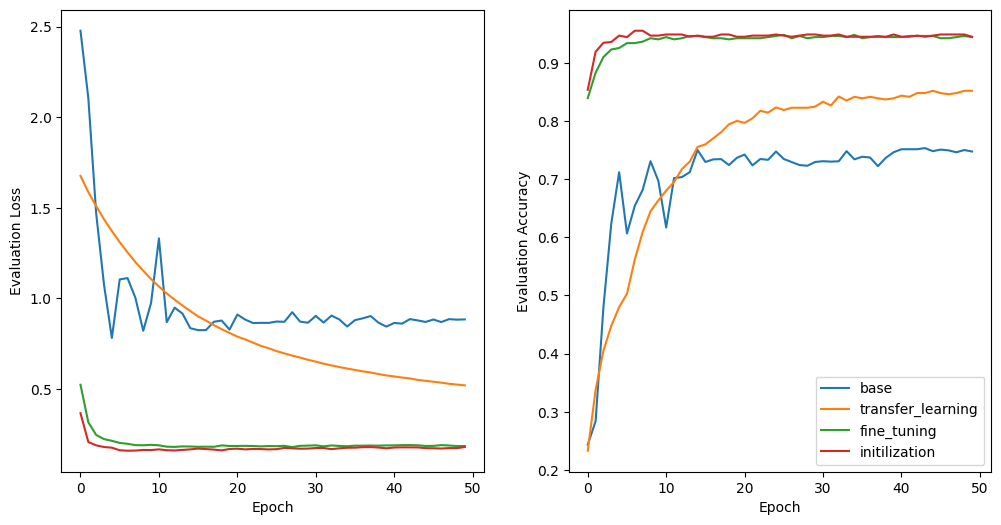

In [ ]:
epochs = list(range(num_epochs))
fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))

metrics = [base_metrics, transfer_metrics, fine_tuning_metrics, initilization_metrics]
lables_plt = ["base", "transfer_learning", "fine_tuning", "initilization"]

for idx, metric in enumerate(metrics):
    axs[0].plot(epochs, metric['valid_loss'], label=lables_plt[idx])
    axs[1].plot(epochs, metric['valid_accuracy'], label=lables_plt[idx])
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Evaluation Loss")
axs[1].set_ylabel("Evaluation Accuracy")
plt.legend()

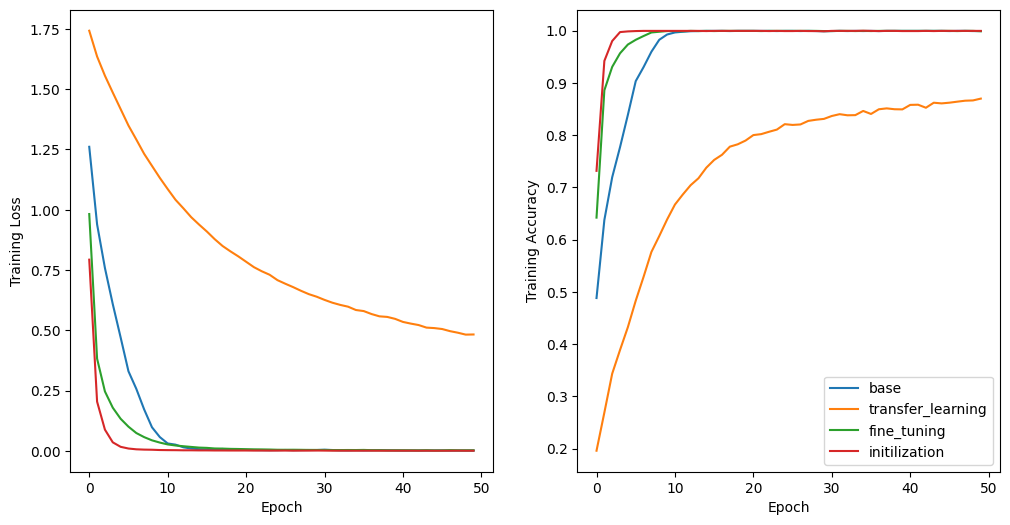

In [ ]:
epochs = list(range(num_epochs))
fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))

metrics = [base_metrics, transfer_metrics, fine_tuning_metrics, initilization_metrics]
lables_plt = ["base", "transfer_learning", "fine_tuning", "initilization"]

for idx, metric in enumerate(metrics):
    axs[0].plot(epochs, metric['train_loss'], label=lables_plt[idx])
    axs[1].plot(epochs, metric['train_accuracy'], label=lables_plt[idx])
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Training Loss")
axs[1].set_ylabel("Training Accuracy")
plt.legend()